## Task 2a
Create cluster-irrelevant features in the data by e.g. perturbing features or replace with simulated noise features. Note, it is probably easier if you first filter out some cluster relevant features so you have an informative set to start from and keep these intact, but you are free to investigate the question of noisy features in other ways if you prefer.

Investigate how an increasing proportion of cluster-irrelevant features impact clustering and the selection of the number of clusters. Is this sensitive to how you choose to reduce dimensions or select features?

To make this interesting, explore at least 2-3 dimension reduction techniques. You can consider feature selection methods, projections, factorization methods or auto-encoders for example.

### Read data

In [3]:
import pyreadr
import numpy as np
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Loads the data
TCGAData = pyreadr.read_r('TCGAdata.RData') 

In [15]:
#Converts it to np.arrays and seperates labels form data
data = np.array(TCGAData['TCGA'])
labels = np.array(TCGAData['TCGAclassstr'])

unique_labels = np.unique(labels)
print(unique_labels)

values = unique_labels
print(values)
# integer encode

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
print(np.unique(labels))
print(data.shape)

['BC' 'GBM' 'KI' 'LU' 'OV' 'U']
['BC' 'GBM' 'KI' 'LU' 'OV' 'U']
[0 1 2 3 4 5]
(2887, 20530)


C:\Users\axelq\OneDrive\Skrivbord\MpCas\Statistical learning for big data\bigdatavenv1\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Feature selection

***PCA***

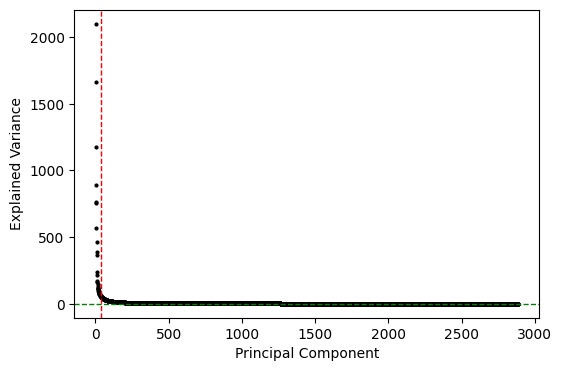

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data_pp = StandardScaler().fit_transform(data)
pca = PCA(svd_solver="auto").fit(data_pp)
# The PCA object offers convenient ways of accessing the
# principal directions and explained variance
pca.components_;
pca.explained_variance_;

# To get the principal components, the `transform` method of the
# PCA object can be used
principal_components_pca = pca.transform(data_pp)

fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.components_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(40, linestyle="dashed", color="red", linewidth=1)
ax.axhline(1, linestyle="dashed", color="green", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca(data, n_components):
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Fit PCA to the scaled data
    pca = PCA(n_components=n_components)
    pca.fit(scaled_data)
    
    # Transform the data using the fitted PCA model
    principal_components = pca.transform(scaled_data)
    
    # Return the principal components and explained variance ratio
    return principal_components

***Random projection

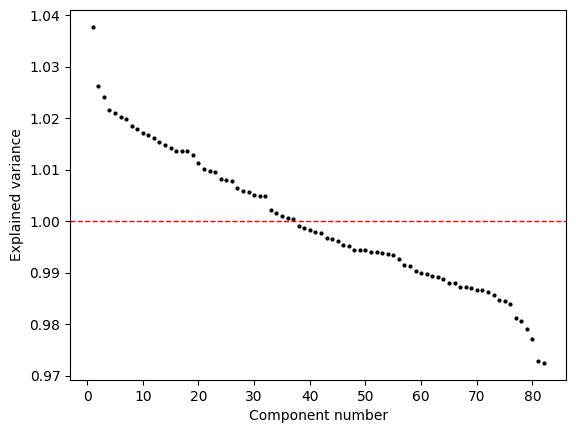

Number of components = 37


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(n_components=82).fit(data)

# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]

# Plot the scree plot
plt.plot(np.arange(1, len(explained_variances) + 1), explained_variances_sorted, 'ok',markersize=2)
plt.axhline(1, linestyle="dashed", color="red", linewidth=1)
plt.xlabel('Component number')
plt.ylabel('Explained variance')
plt.show()

n_components = np.sum(explained_variances_sorted > 1)
print(f'Number of components = {n_components}')

In [12]:
def random_projection(data, nr_components):
    scaled_data = StandardScaler().fit_transform(data)
    return GaussianRandomProjection(n_components=nr_components).fit_transform(scaled_data)
    